In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import label

In [2]:
def load_image(file_path, gray=True):
    if gray:
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return image

def region_based_segmentation(image):
    """Simple region-based segmentation using histogram thresholds."""
    threshold1, threshold2 = np.percentile(image, [25, 75])
    markers = np.zeros_like(image, dtype=np.uint8)
    markers[image < threshold1] = 1  # Background
    markers[image > threshold2] = 2  # Foreground
    return markers

def denoise_segmentation(segmentation, neighborhood=8, threshold=0.5, iterations=1):
    """Denoise segmentation using majority voting."""
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]]) if neighborhood == 8 else np.array([[0, 1, 0],
                                                                         [1, 0, 1],
                                                                         [0, 1, 0]])
    cleaned_segmentation = segmentation.copy()
    for _ in range(iterations):
        labeled, _ = label(cleaned_segmentation)
        for i in range(1, labeled.max() + 1):
            mask = labeled == i
            neighbor_sum = cv2.filter2D(mask.astype(np.float32), -1, kernel, borderType=cv2.BORDER_CONSTANT)
            votes = (neighbor_sum / kernel.sum()) > threshold
            cleaned_segmentation[mask] = np.round(votes[mask]).astype(np.uint8)
    return cleaned_segmentation

def visualize_results(original, markers, cleaned, title):
    """Visualize original, segmented, and cleaned images."""
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original, cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title("Region-Based Segmentation")
    plt.imshow(markers, cmap='viridis')
    plt.subplot(1, 3, 3)
    plt.title(title)
    plt.imshow(cleaned, cmap='viridis')
    plt.show()

Processing camera...


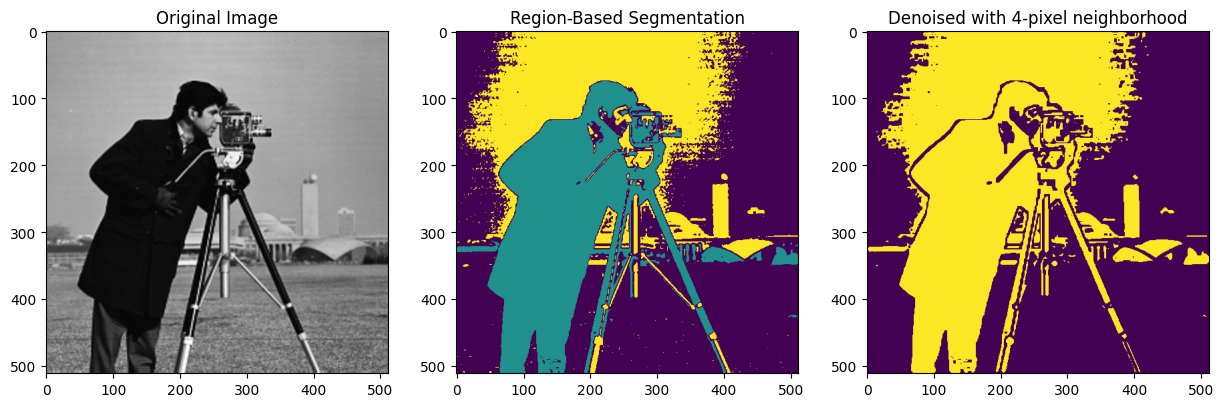

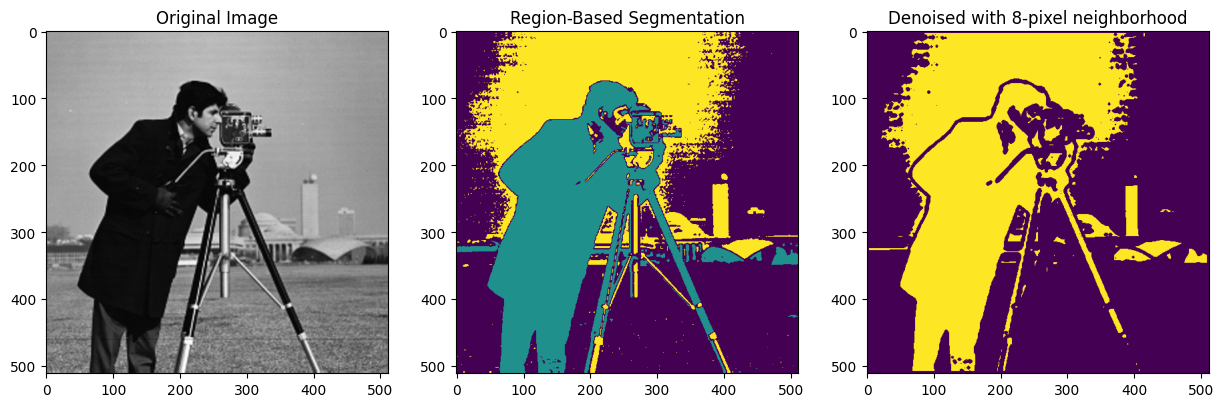

Finished processing camera.
Processing coins...


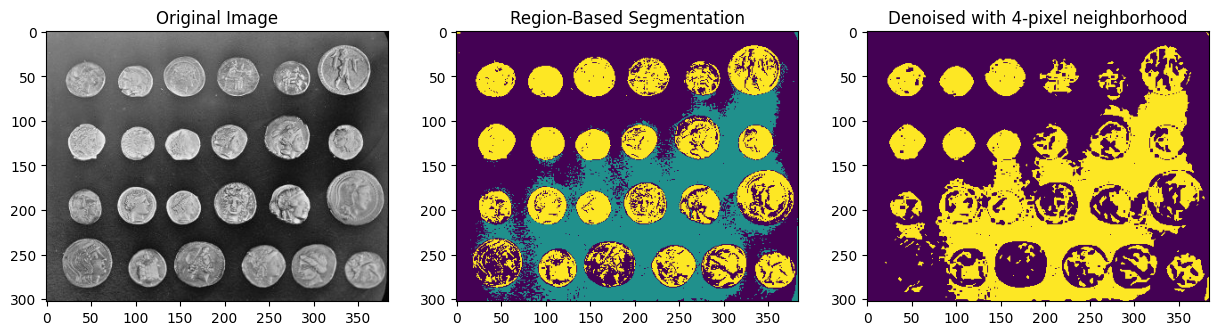

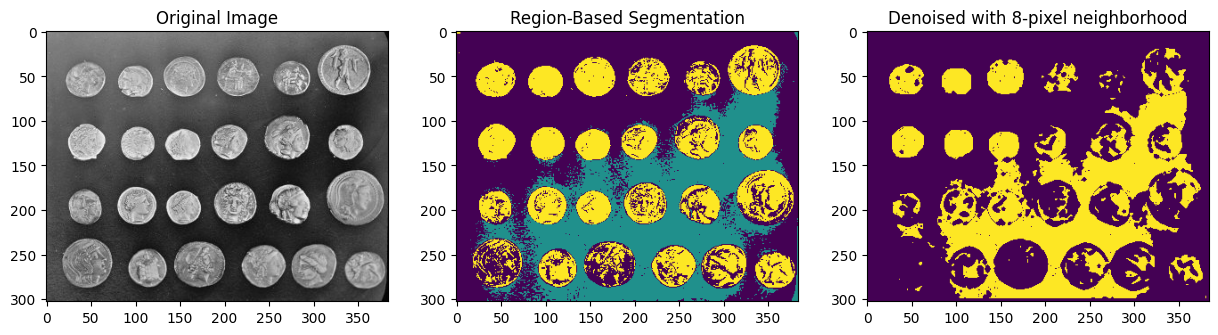

Finished processing coins.
Processing page...


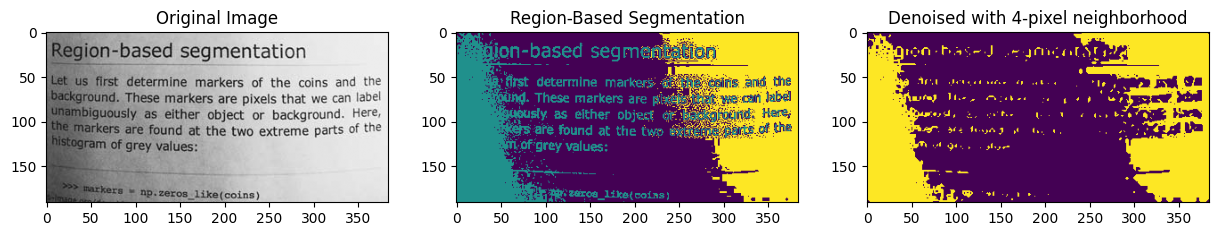

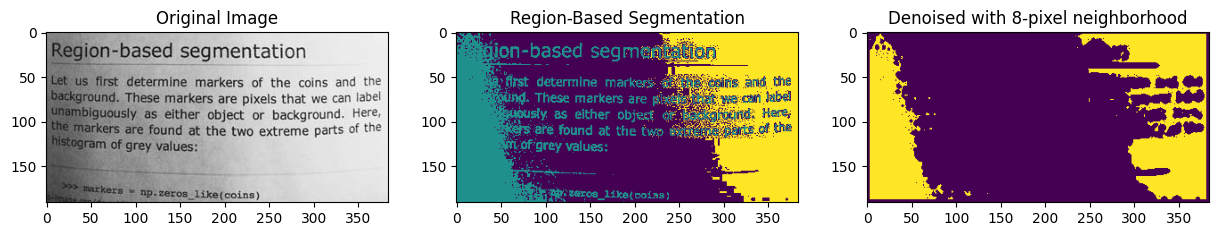

Finished processing page.
Processing rocksample...


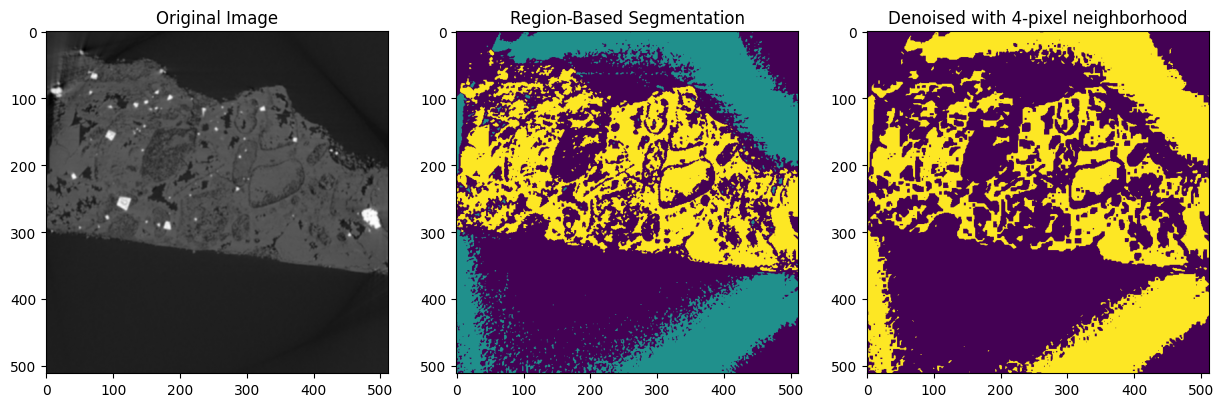

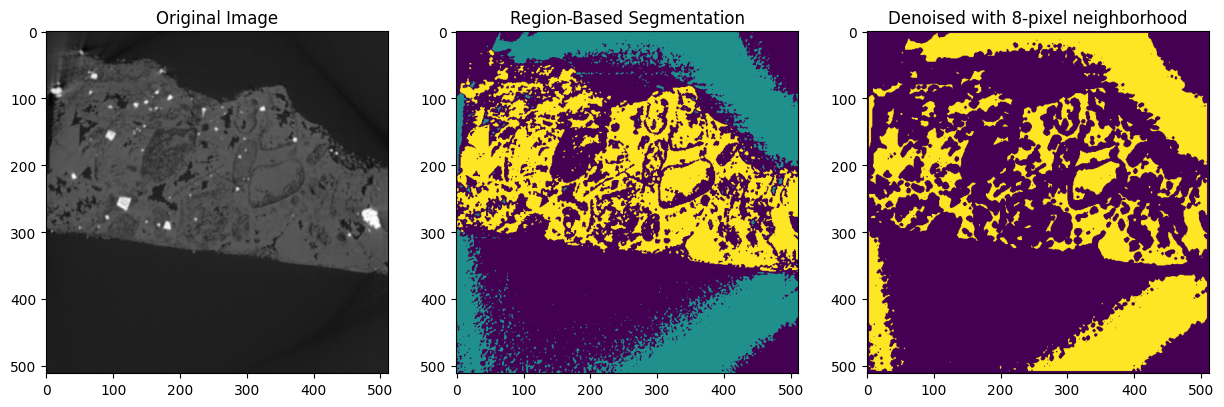

Finished processing rocksample.


In [7]:
image_files = {
    "camera": "/content/camera.png",
    "coins": "/content/coins.png",
    "page": "/content/page.png",
    "rocksample": "/content/rocksample.png"
}

for name, file_path in image_files.items():
    print(f"Processing {name}...")

    image = load_image(file_path)
    if name == "rocksample":
        image = cv2.resize(image, (512, 512))  # Resize to manageable dimensions
        image = cv2.GaussianBlur(image, (5, 5), 0)  # Reduce complexity

    markers = region_based_segmentation(image)

    cleaned_4 = denoise_segmentation(markers, neighborhood=4, threshold=0.5, iterations=3)
    cleaned_8 = denoise_segmentation(markers, neighborhood=8, threshold=0.66, iterations=3)

    visualize_results(image, markers, cleaned_4, f"Denoised with 4-pixel neighborhood")
    visualize_results(image, markers, cleaned_8, f"Denoised with 8-pixel neighborhood")

    print(f"Finished processing {name}.")

In [8]:
def multi_label_denoise_segmentation(segmentation, labels, neighborhood=8, threshold=0.5, iterations=1):
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]]) if neighborhood == 8 else np.array([[0, 1, 0],
                                                                         [1, 0, 1],
                                                                         [0, 1, 0]])
    cleaned_segmentation = segmentation.copy()
    for _ in range(iterations):
        new_segmentation = np.zeros_like(cleaned_segmentation)
        for label in labels:
            mask = cleaned_segmentation == label
            neighbor_sum = cv2.filter2D(mask.astype(np.float32), -1, kernel, borderType=cv2.BORDER_CONSTANT)
            votes = (neighbor_sum / kernel.sum()) > threshold
            new_segmentation[votes] = label
        cleaned_segmentation = new_segmentation
    return cleaned_segmentation

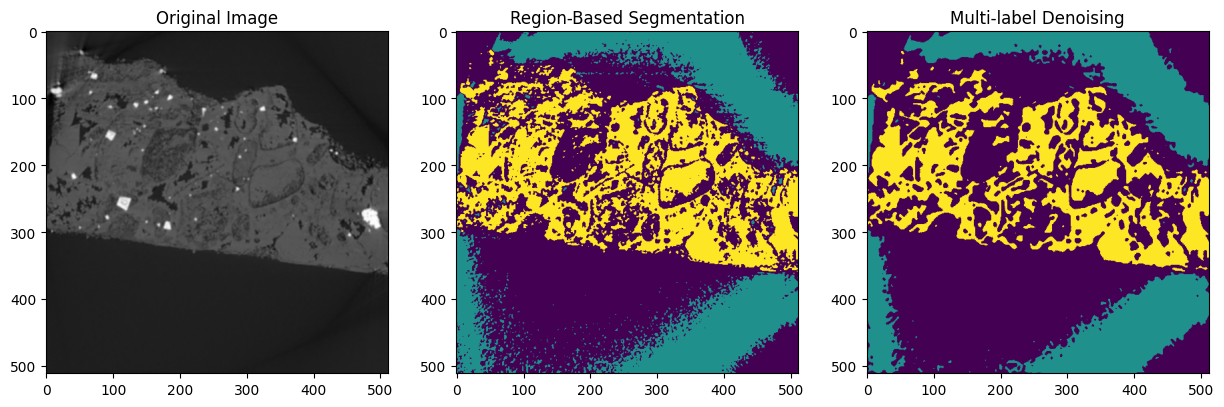

In [9]:
multi_labels = np.unique(markers)
cleaned_multi = multi_label_denoise_segmentation(markers, multi_labels, neighborhood=8, threshold=0.6, iterations=3)
visualize_results(image, markers, cleaned_multi, "Multi-label Denoising")


Processing camera...


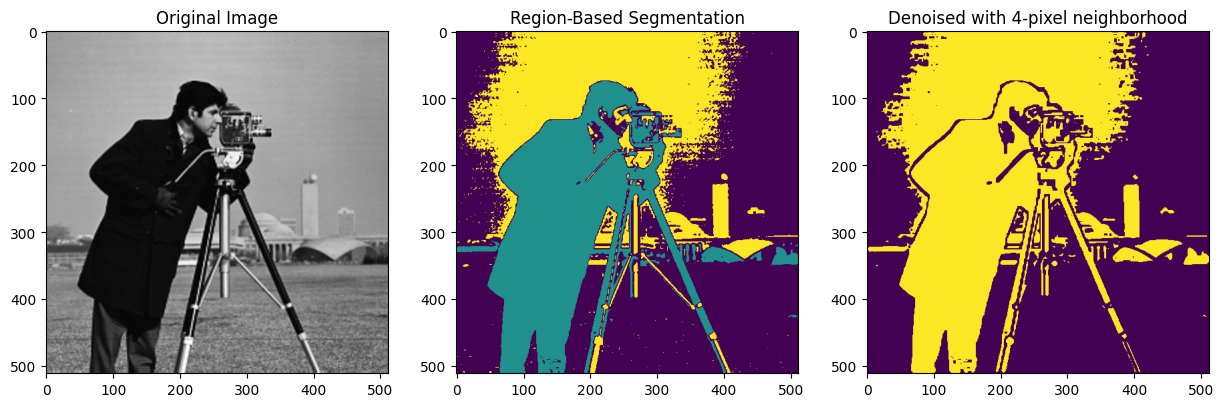

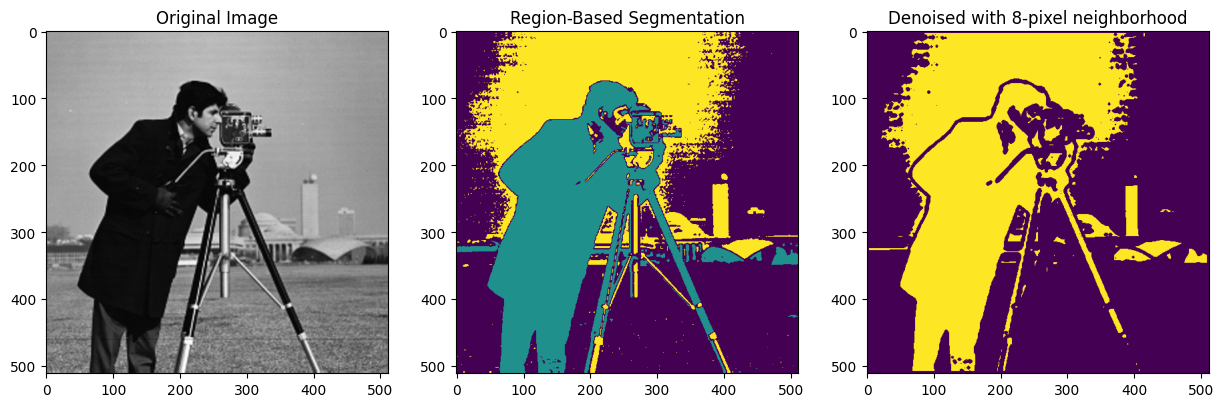

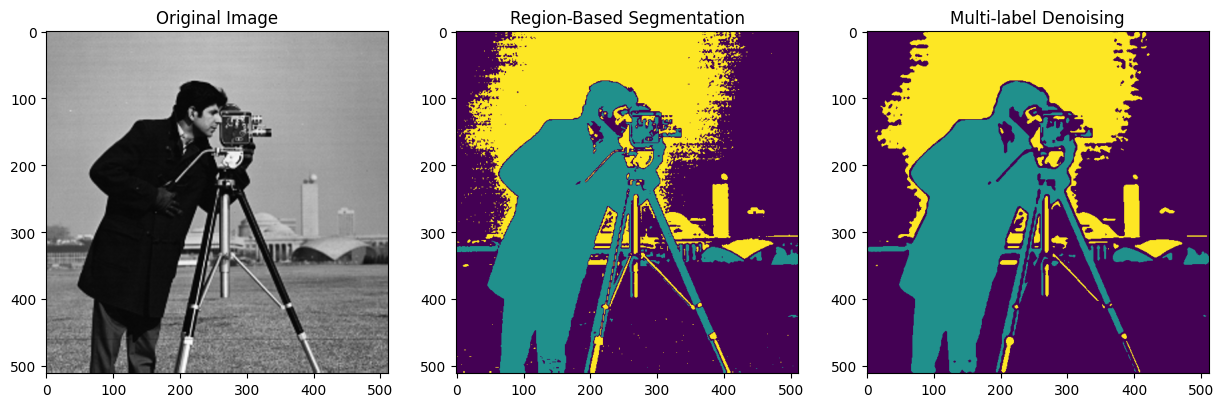

Finished processing camera.
Processing coins...


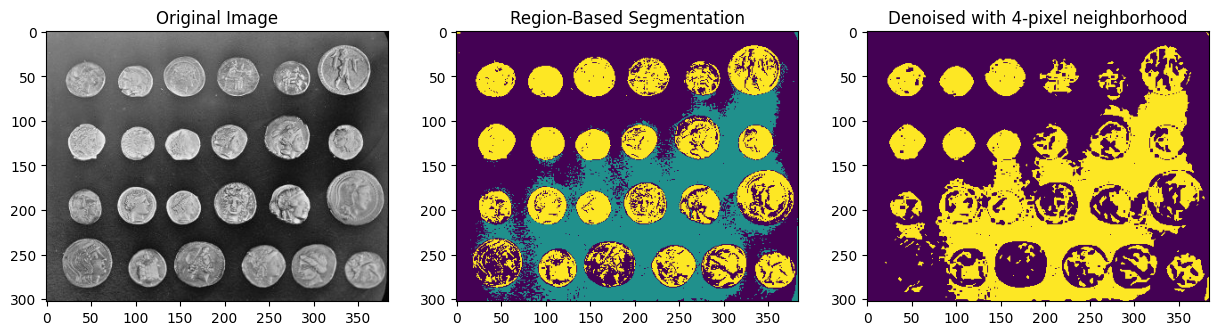

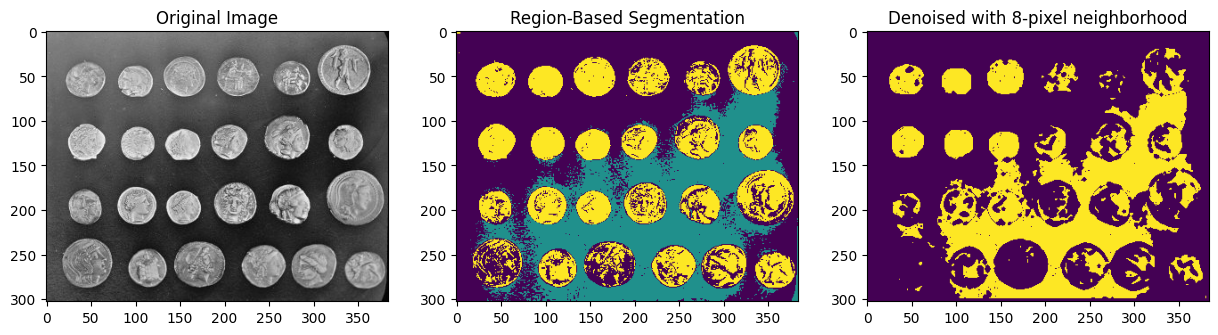

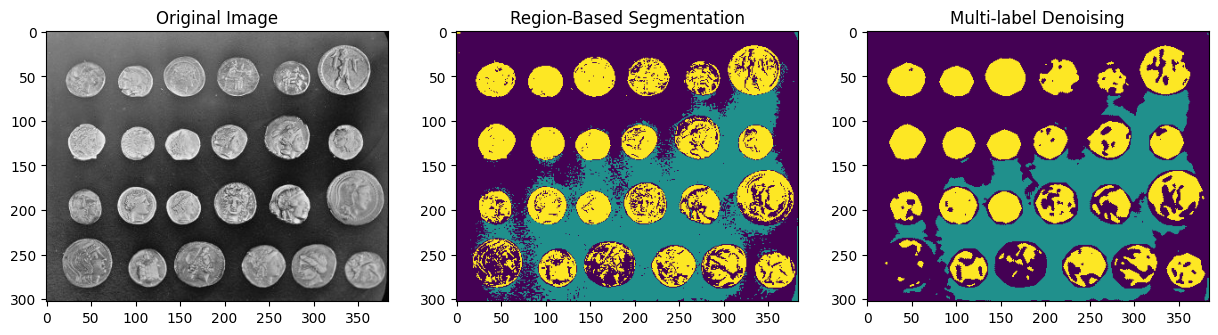

Finished processing coins.
Processing page...


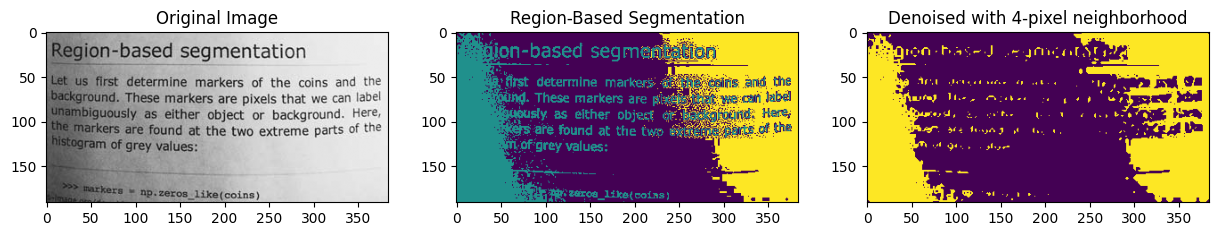

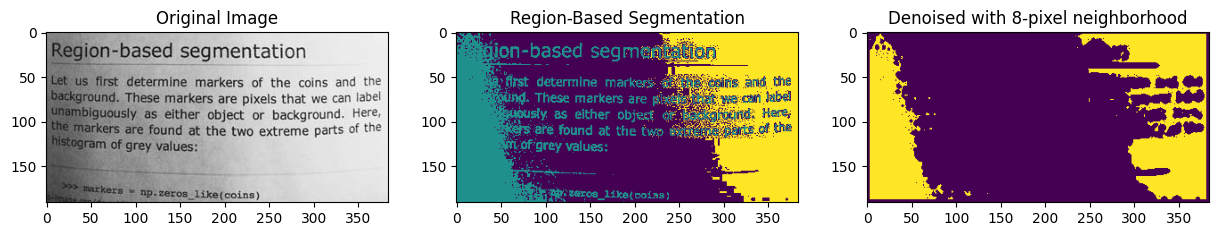

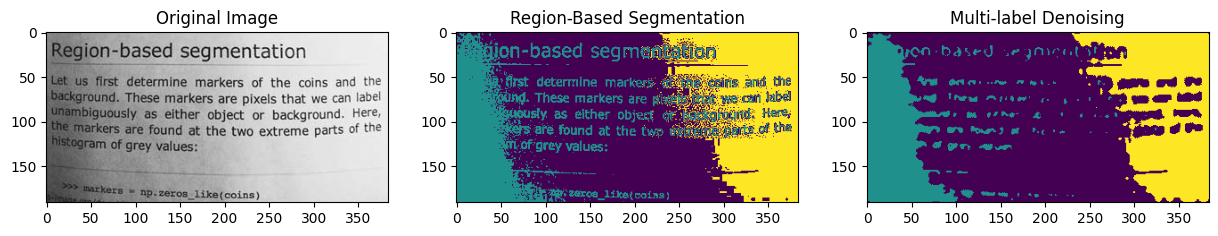

Finished processing page.
Processing rocksample...


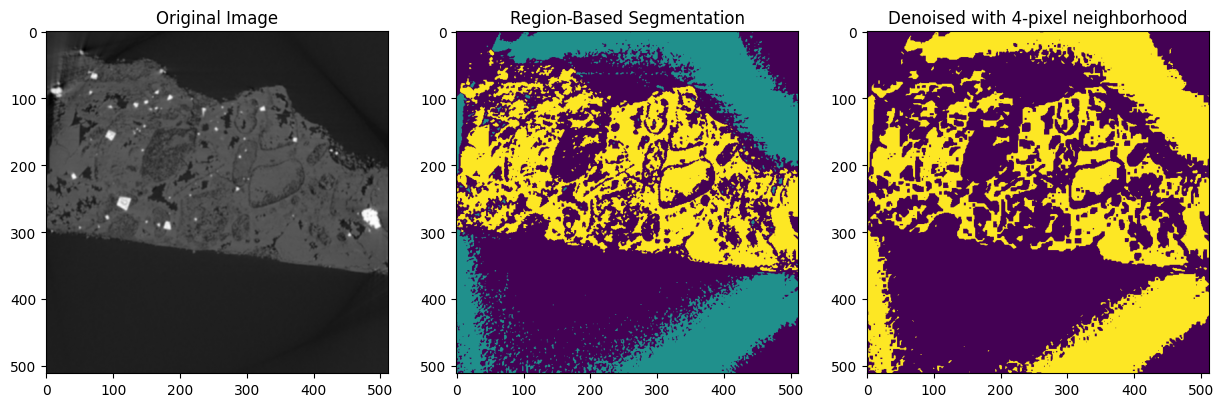

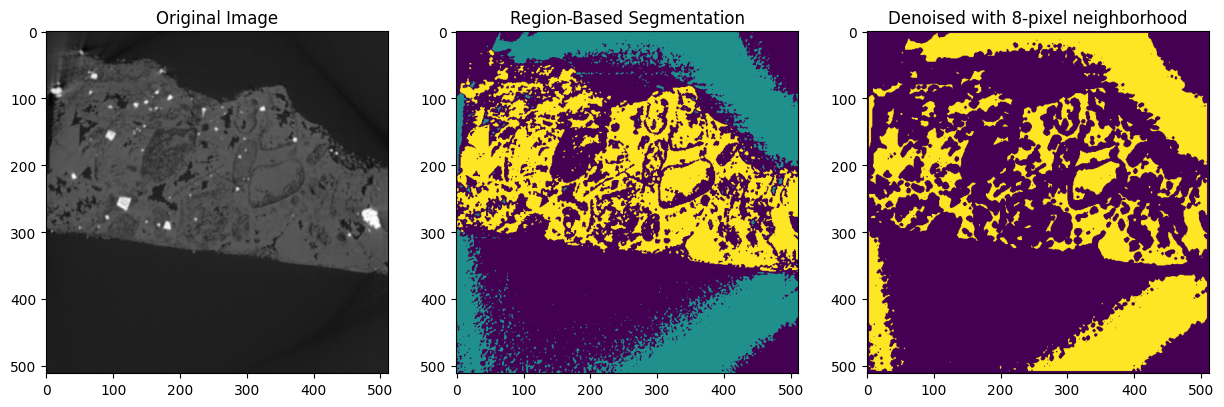

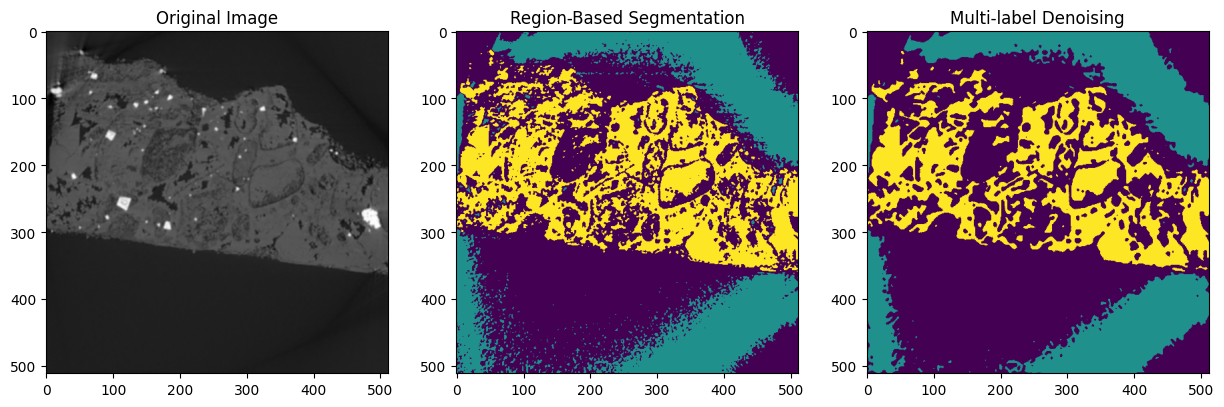

Finished processing rocksample.


In [10]:
for name, file_path in image_files.items():
    print(f"Processing {name}...")

    # Load the image
    image = load_image(file_path)
    if name == "rocksample":
        image = cv2.resize(image, (512, 512))  # Resize to manageable dimensions
        image = cv2.GaussianBlur(image, (5, 5), 0)  # Reduce complexity

    # region-based segmentation
    markers = region_based_segmentation(image)

    # Denoise with varying parameters
    cleaned_4 = denoise_segmentation(markers, neighborhood=4, threshold=0.5, iterations=3)
    cleaned_8 = denoise_segmentation(markers, neighborhood=8, threshold=0.66, iterations=3)

    # Visualize results for denoising
    visualize_results(image, markers, cleaned_4, f"Denoised with 4-pixel neighborhood")
    visualize_results(image, markers, cleaned_8, f"Denoised with 8-pixel neighborhood")

    # Multi-label denoising
    multi_labels = np.unique(markers)
    cleaned_multi = multi_label_denoise_segmentation(markers, multi_labels, neighborhood=8, threshold=0.6, iterations=3)
    visualize_results(image, markers, cleaned_multi, "Multi-label Denoising")

    print(f"Finished processing {name}.")